In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
df = pd.read_csv('StackOverflow.csv')[['month', 'matlab']]
df['month'] = pd.to_datetime(df['month'], format='%y-%b')
df.set_index('month', inplace=True)
df.head()

,matlab
month,
2009-01-01,19
2009-02-01,27
2009-03-01,24
2009-04-01,32
2009-05-01,42


<Axes: xlabel='month'>

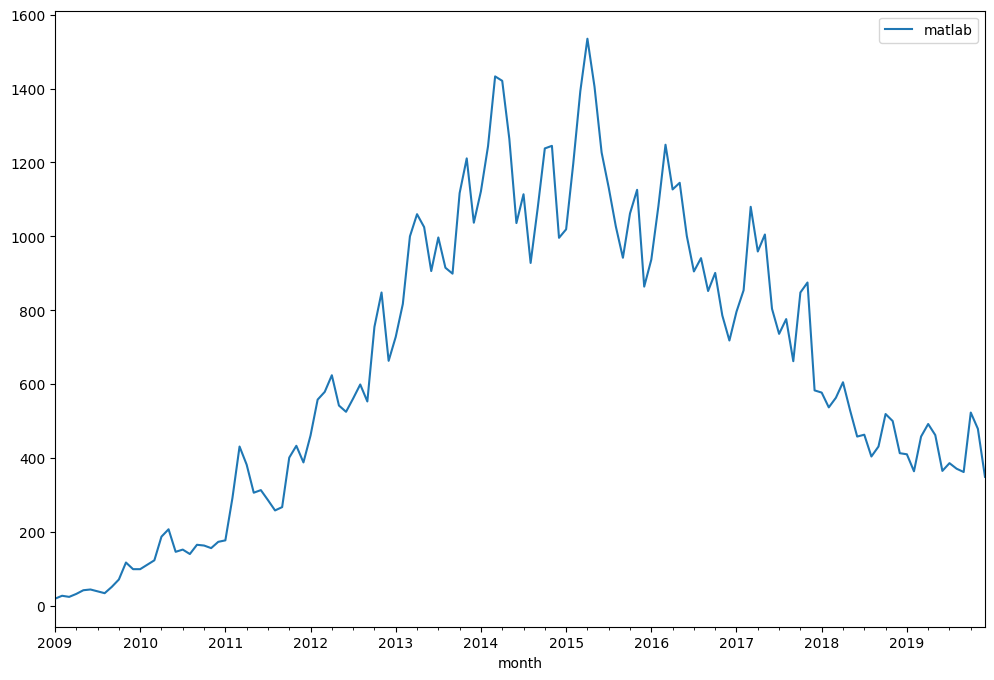

In [46]:
df.plot(legend=True,label='matlab',figsize=(12,8))

In [47]:
import seaborn as sns

Text(0.5, 0, '')

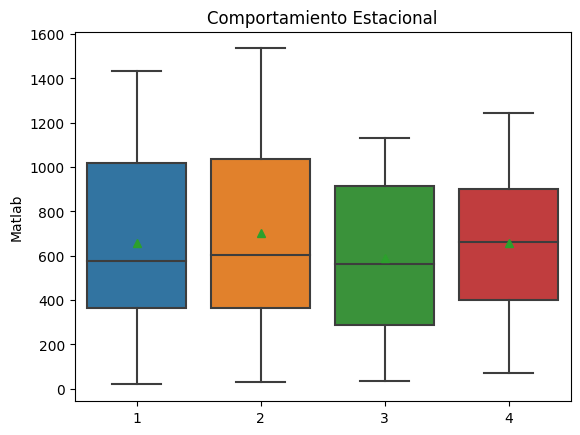

In [48]:
df['month'] = df.index.quarter

sns.boxplot(data=df, x='month', y='matlab',showmeans=True)
ax = plt.gca()
ax.set_ylabel('Matlab')
ax.set_title('Comportamiento Estacional')
ax.set_xlabel('')

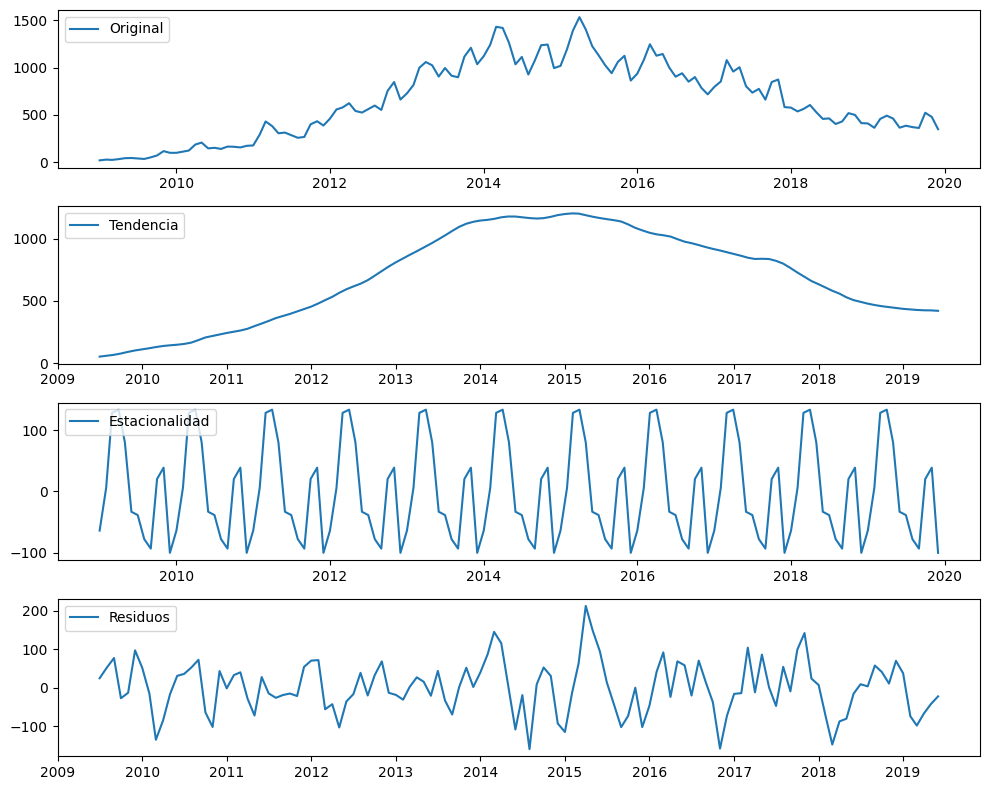

In [49]:
import statsmodels.api as sm


decomposition = sm.tsa.seasonal_decompose(df['matlab'], model='additive')

fig, axes = plt.subplots(4, 1, figsize=(10, 8))

axes[0].plot(df.index, decomposition.observed, label='Original')
axes[0].legend(loc='upper left')
axes[1].plot(df.index, decomposition.trend, label='Tendencia')
axes[1].legend(loc='upper left')
axes[2].plot(df.index, decomposition.seasonal, label='Estacionalidad')
axes[2].legend(loc='upper left')
axes[3].plot(df.index, decomposition.resid, label='Residuos')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [52]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train_0, y_test = temporal_train_test_split(y = df['matlab'].astype('float64').to_period('m'), test_size=6)
y_train_1, y_validation_1 = temporal_train_test_split(y = y_train_0.astype('float64'), test_size=12)

# ETS

In [20]:
from sktime.forecasting.ets import AutoETS

In [54]:
ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
ets_model.fit(y_train_0)
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:                 matlab   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -690.953
Date:                Tue, 07 Nov 2023   AIC                           1417.907
Time:                        00:57:48   BIC                           1468.960
Sample:                    01-31-2009   HQIC                          1438.648
                         - 06-30-2019   Scale                            0.015
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.107      9.376      0.000       0.791       1.209
smoothing_trend         0.0182      0.022      0.834      0.404      -0.025       0.061
smoothing_season

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

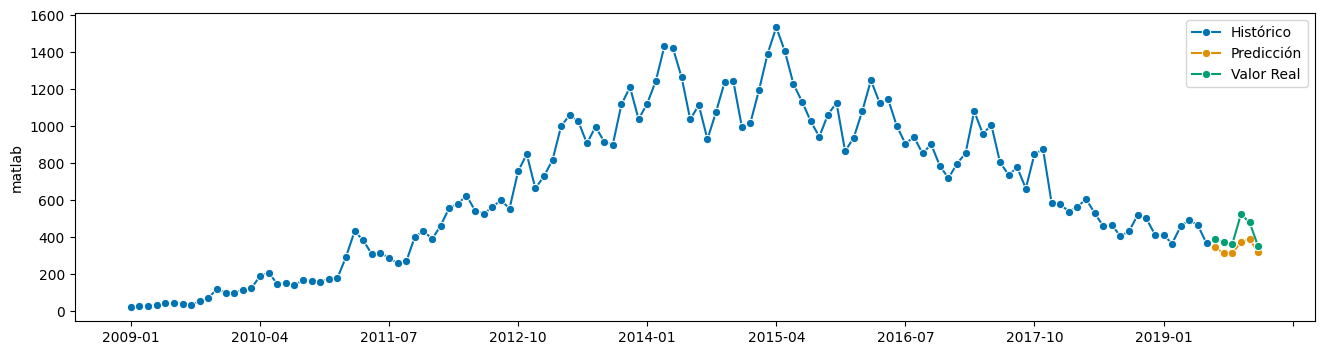

In [64]:
horizon = np.arange(1, 7)
ets_prediction = ets_model.predict(horizon)
ets_intervals = ets_model.predict_interval(horizon, coverage=0.9)
plot_series(y_train_0, ets_prediction, y_test, labels=["Histórico", "Predicción", "Valor Real"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

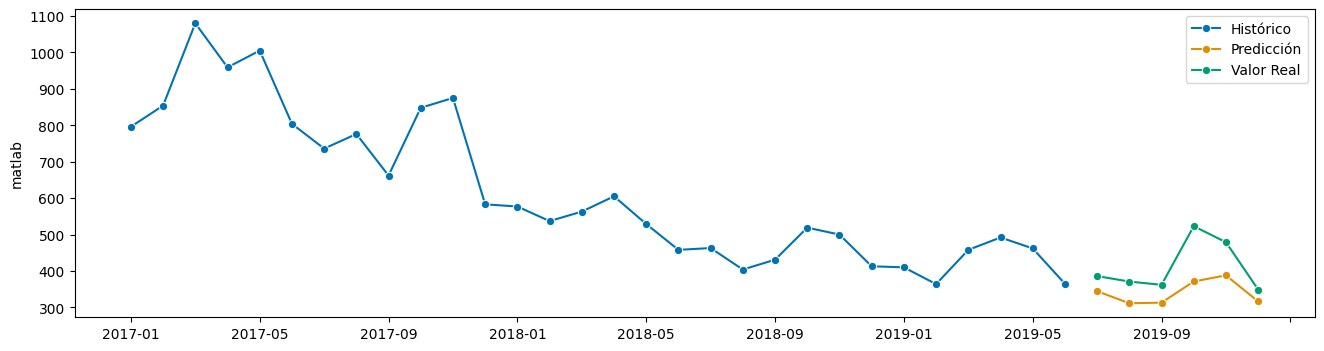

In [65]:
plot_series(y_train_0['2017':], ets_prediction, y_test, labels=["Histórico", "Predicción", "Valor Real"])

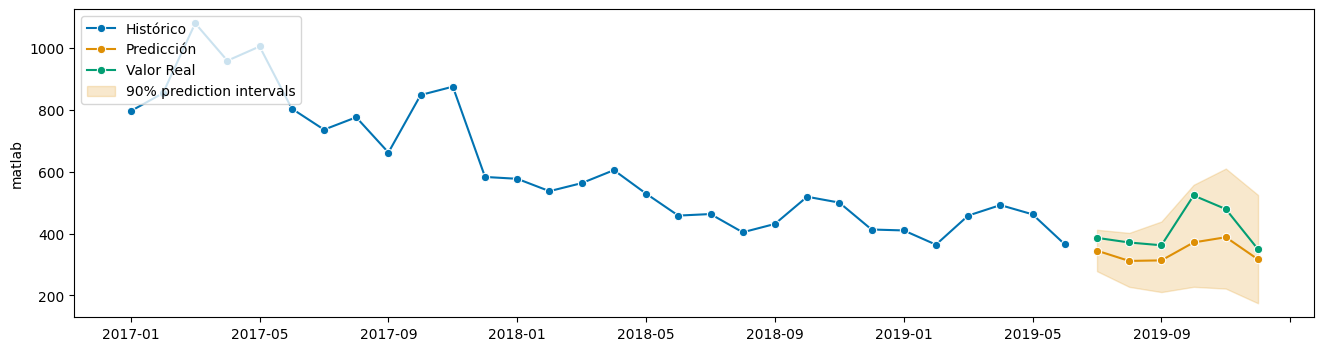

In [66]:
fig, ax = plot_series(y_train_0['2017':], ets_prediction, y_test, labels=["Histórico", "Predicción", "Valor Real"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_intervals[('matlab', 0.9, 'lower')],
    ets_intervals[('matlab', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')


In [153]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface

ets = mean_absolute_percentage_error(y_test, ets_prediction[0:8])
ets

0.16278756408015796

In [68]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, ets_prediction[0:8])

6673.546147936121

In [69]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ets_prediction[0:8])

81.69177527717292

# ARIMA

In [70]:
from sktime.transformations.series.boxcox import LogTransformer

Text(0.5, 1.0, 'matlab con transformación logaritmica')

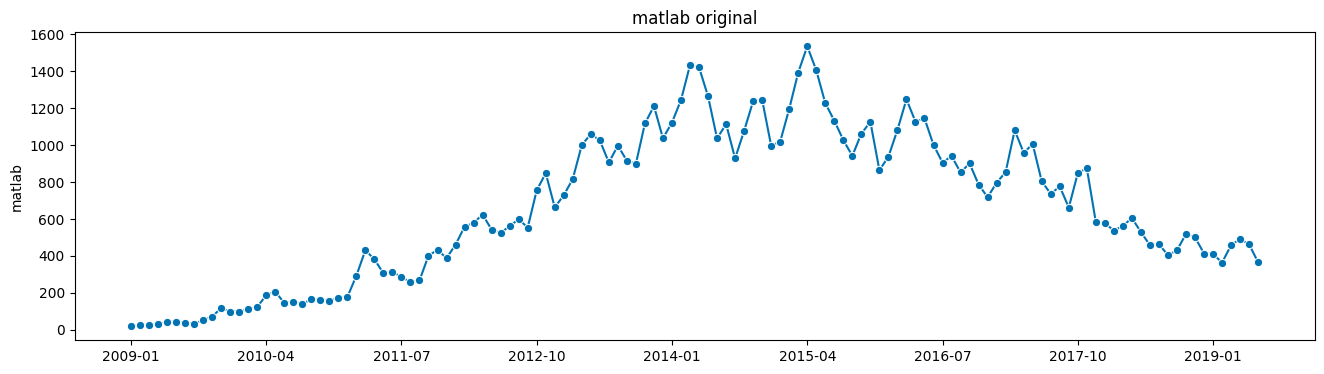

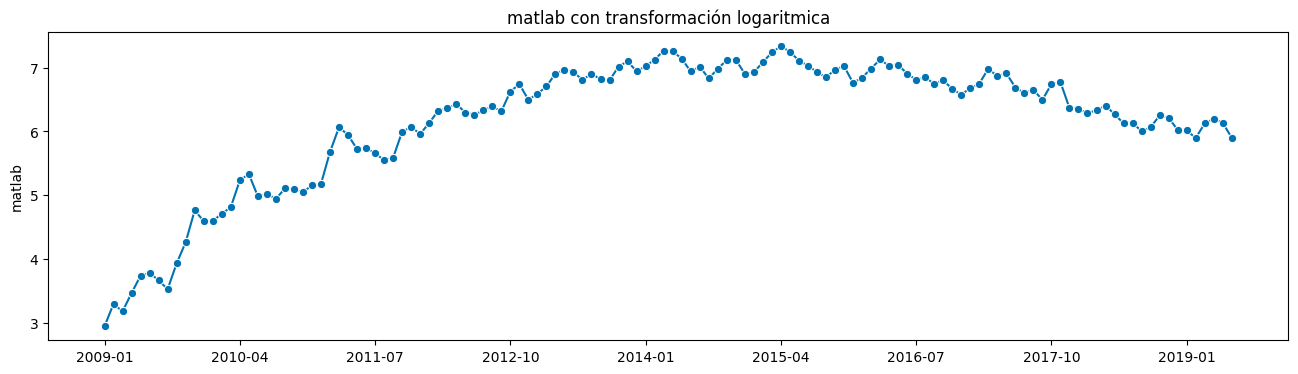

In [71]:
transformer = LogTransformer()
transformer = transformer.fit(y_train_0)
y_train_log = transformer.transform(y_train_0)
y_test_log = transformer.transform(y_test)


fig, ax =plot_series(y_train_0)
ax.set_title('matlab original')
fig, ax =plot_series(y_train_log)
ax.set_title('matlab con transformación logaritmica')

In [72]:
# Autocorrelation Fuction Package
from sktime.utils.plotting import plot_correlations

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='matlab'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

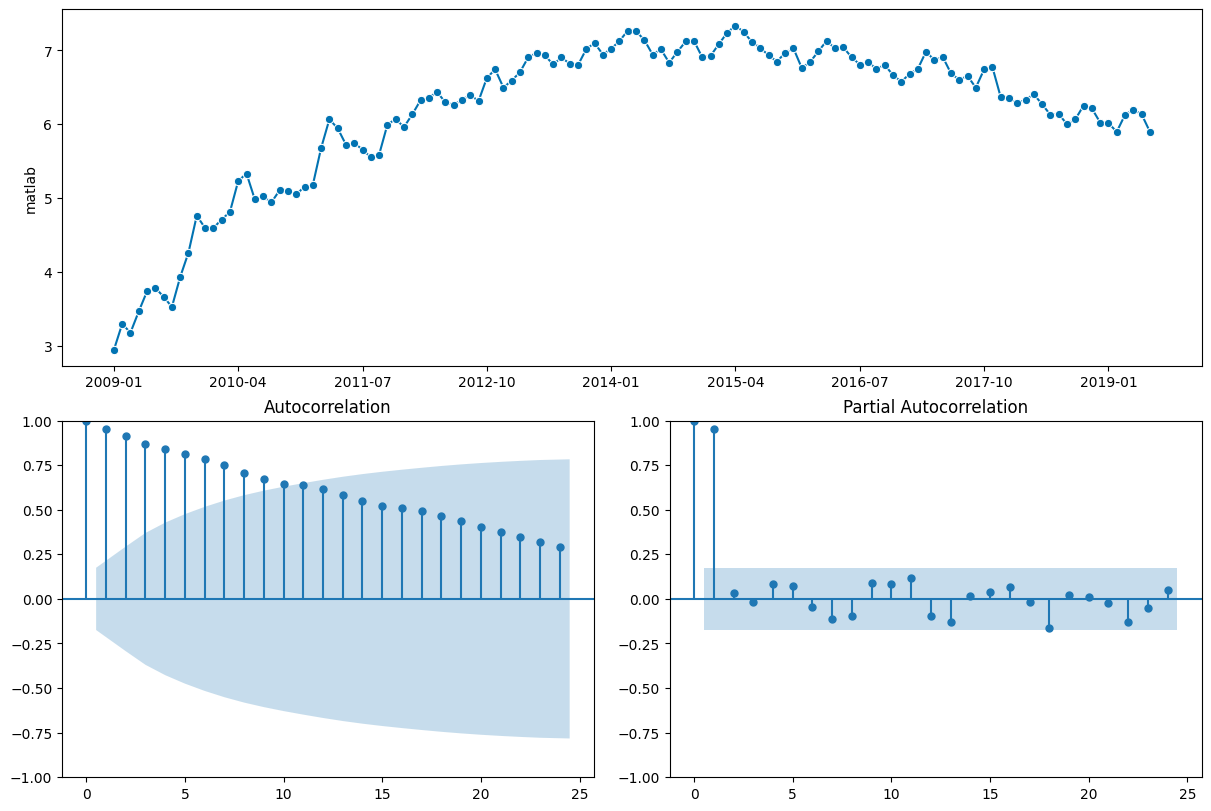

In [73]:
# Autocorrelation Fuction Original Time Series
plot_correlations(y_train_log)

In [74]:
# Difference Fuction Package
from sktime.transformations.series.difference import Differencer

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='matlab'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

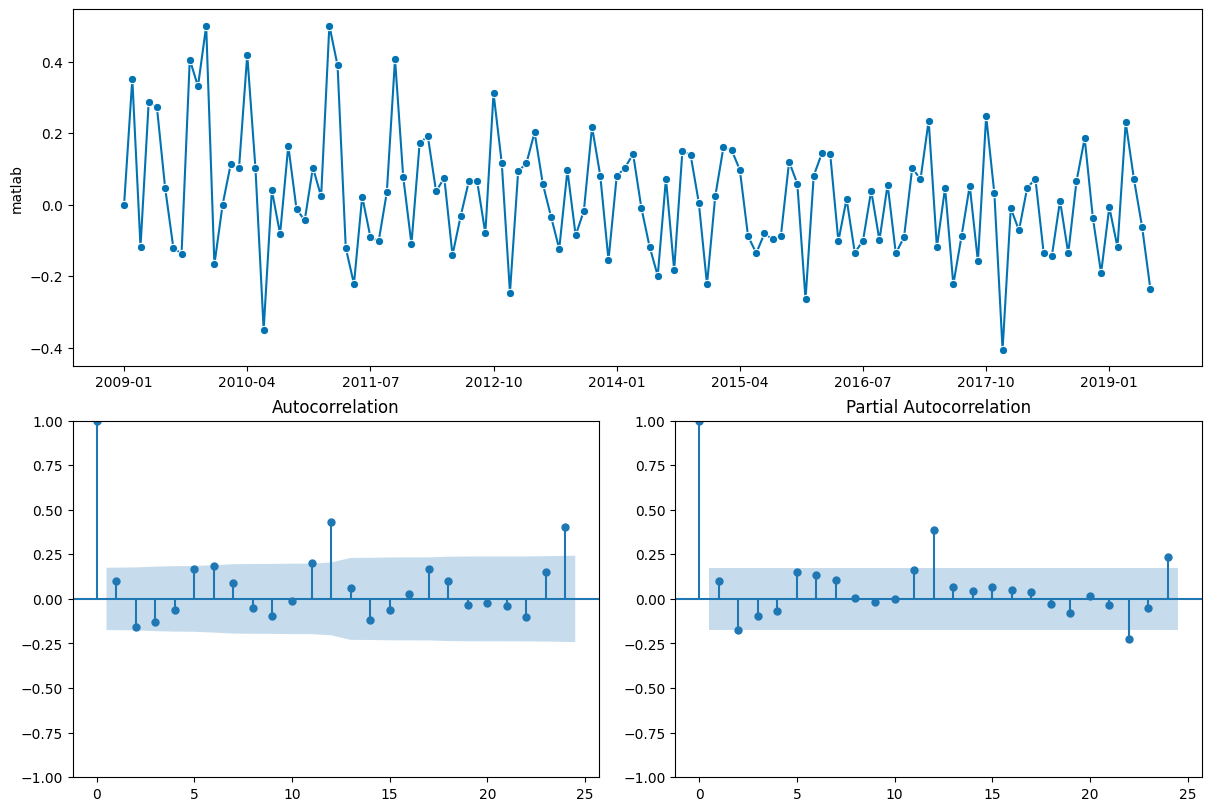

In [75]:
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(y_train_log))

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='matlab'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

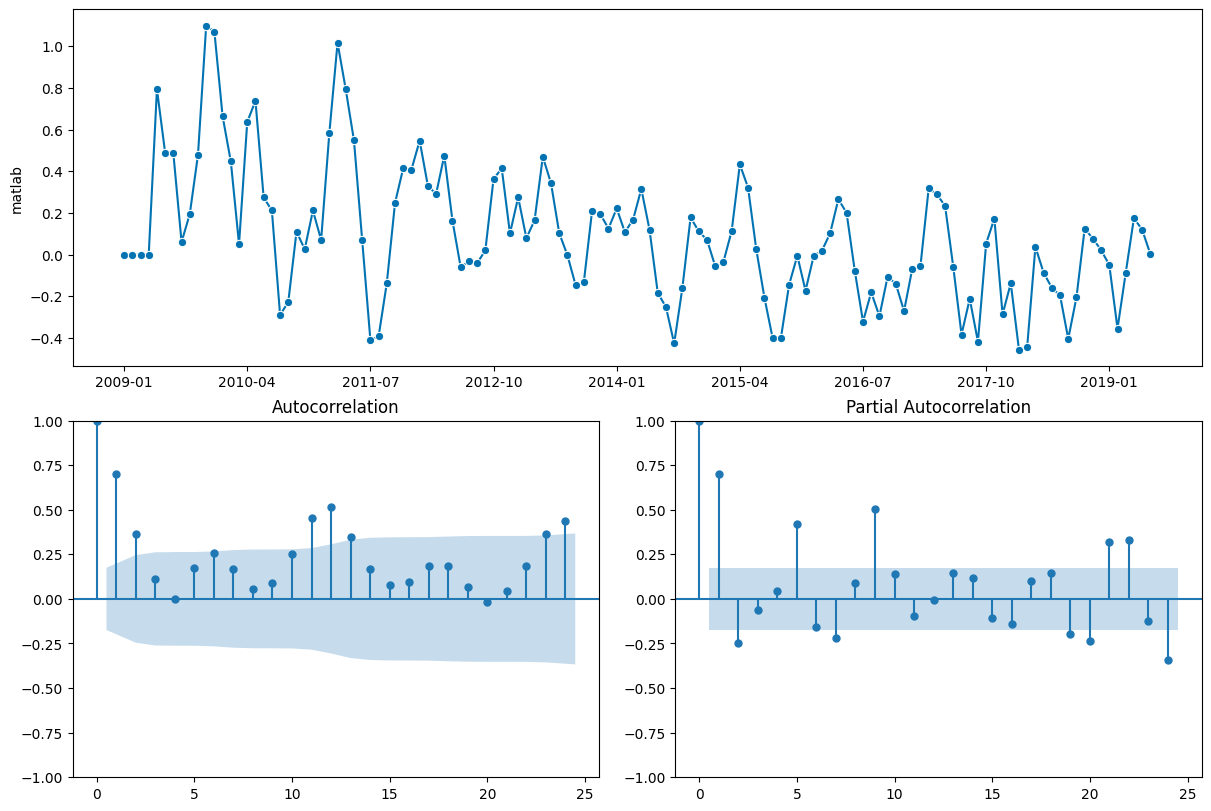

In [76]:
transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(y_train_log))

In [77]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA

In [79]:
arima_model = AutoARIMA(sp=12,suppress_warnings=True, trace=True)
arima_model.fit(y_train_log)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=-16.233, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-45.976, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-18.177, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12] intercept   : AIC=-29.167, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12] intercept   : AIC=-51.909, Time=0.55 sec
 ARIMA(1,2,0)(2,0,1)[12] intercept   : AIC=-58.896, Time=0.88 sec
 ARIMA(1,2,0)(1,0,1)[12] intercept   : AIC=-60.627, Time=0.38 sec
 ARIMA(1,2,0)(0,0,1)[12] intercept   : AIC=-40.053, Time=0.24 sec
 ARIMA(1,2,0)(1,0,2)[12] intercept   : AIC=-58.996, Time=1.25 sec
 ARIMA(1,2,0)(0,0,2)[12] intercept   : AIC=-43.440, Time=0.47 sec
 ARIMA(1,2,0)(2,0,2)[12] intercept   : AIC=-56.693, Time=1.52 sec
 ARIMA(0,2,0)(1,0,1)[12] intercept   : AIC=-35.313, Time=0.32 sec
 ARIMA(2,2,0)(1,0,1)[12] intercept   : AI

AutoARIMA(sp=12, suppress_warnings=True, trace=True)

In [80]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  126
Model:             SARIMAX(4, 2, 1)x(1, 0, 1, 12)   Log Likelihood                  71.666
Date:                            Tue, 07 Nov 2023   AIC                           -127.332
Time:                                    01:07:53   BIC                           -104.770
Sample:                                01-31-2009   HQIC                          -118.167
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1666      0.088     -1.904      0.057      -0.338       0.005
ar.L2         -0.2627      0.077   

In [81]:
y_pred_log = arima_model.predict(horizon)
np.exp(y_pred_log)

2019-07    328.819804
2019-08    302.392739
2019-09    294.196388
2019-10    334.671391
2019-11    325.712482
2019-12    260.664247
Freq: M, Name: matlab, dtype: float64

In [82]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(y_test_log, y_pred_log)

0.046723223521260175

In [152]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

arima = mean_absolute_percentage_error(y_test, np.exp(y_pred_log))
arima

0.24226382121869813

In [84]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test_log, y_pred_log)

0.3010408403158862

In [85]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(y_pred_log))

114.99405357946432

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

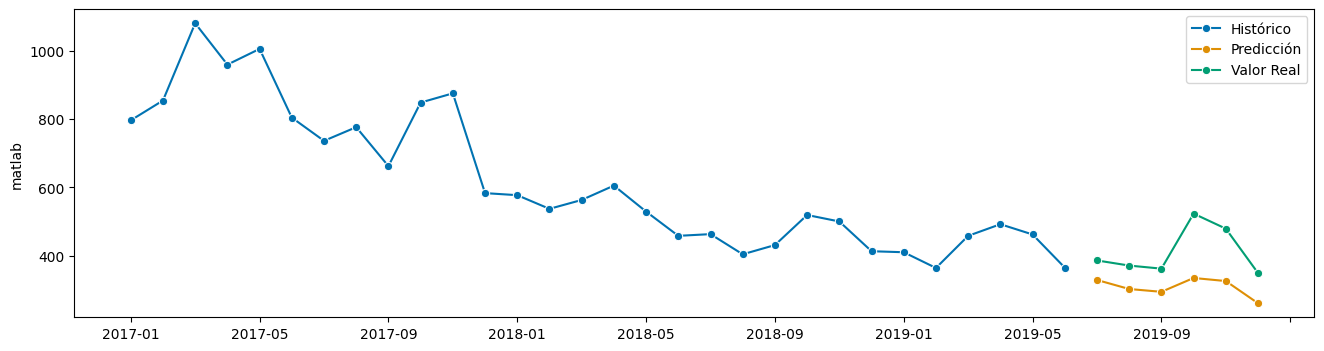

In [88]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train_0['2017':], np.exp(y_pred_log),y_test, labels=["Histórico", "Predicción", "Valor Real"])

# 4Theta

In [89]:
from darts.models import Theta, FourTheta
from darts.metrics import mape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts import TimeSeries

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/home/codespace/.python/current/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [136]:
df2 = df.copy()
df2.reset_index(level=0, inplace=True)

df_ts = TimeSeries.from_dataframe (df2,'month','matlab')
train, test = df_ts.split_before(pd.Timestamp("20190701"))

In [137]:
fourtheta1 =FourTheta(seasonality_period=12)
fourtheta1.fit(train)
prediccion_4theta = fourtheta1.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(fourtheta1, mape(test, prediccion_4theta)))

model FourTheta(seasonality_period=12) obtains MAPE: 41.10%


Text(0.5, 1.0, '4Theta model')

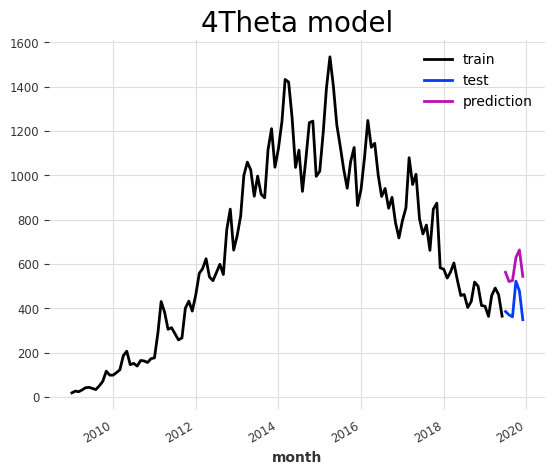

In [138]:
train.plot(label="train")
test.plot(label="test")
prediccion_4theta.plot(label="prediction")

plt.title(label="4Theta model",
          fontsize=20,
          color="black")

In [139]:
fourtheta_grid = {
    #'theta':2- np.linspace(-10, 10, 10),
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=fourtheta_grid,
                                series=train,
                                forecast_horizon=36, # 12
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost`

(FourTheta(theta=1, seasonality_period=None, season_mode=SeasonalityMode.MULTIPLICATIVE, model_mode=ModelMode.ADDITIVE, trend_mode=TrendMode.EXPONENTIAL, normalization=True),
 {'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 44.399022105125766)

Text(0.5, 1.0, 'Best 4Theta model')

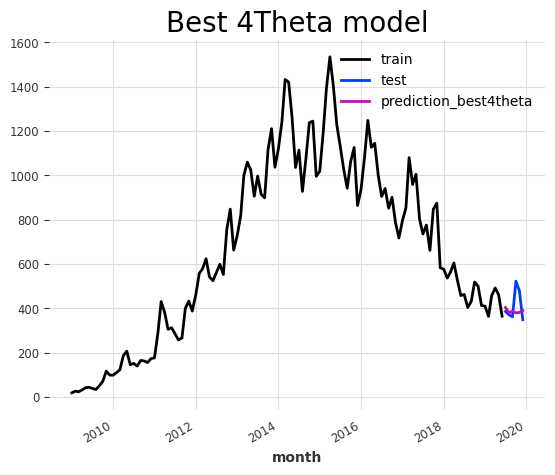

In [140]:
model_bestfourtheta=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.MULTIPLICATIVE,
                 trend_mode=TrendMode.LINEAR
                 )
model_bestfourtheta.fit(train)
prediction_best4theta = model_bestfourtheta.predict(len(test))

train.plot(label="train")
test.plot(label="test")
prediction_best4theta.plot(label="prediction_best4theta")

plt.title(label="Best 4Theta model",
          fontsize=20,
          color="black")

In [141]:
thetas = 2- np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0


for theta in thetas:

    model_4theta = Theta(theta)
    model_4theta.fit(train)
    prediction_4theta = model_4theta.predict(len(test))
    res = mape(test, prediction_4theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [142]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

<Axes: xlabel='month'>

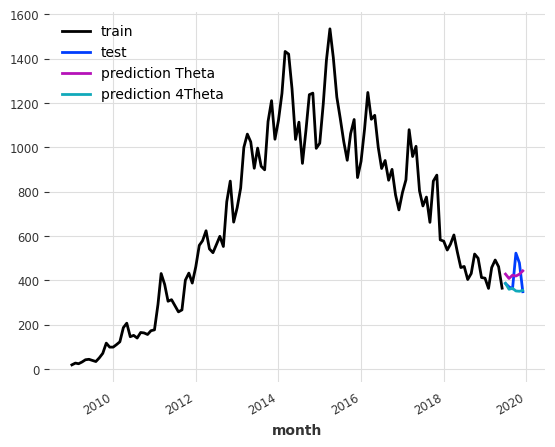

In [143]:
train.plot(label="train")
test.plot(label="test")
prediction_4theta.plot(label="prediction Theta")
pred_best_theta.plot(label="prediction 4Theta")

In [144]:
theta = mape(test,prediction_4theta)
theta

15.93284089399814

In [145]:
best4theta = mape (test, prediction_best4theta)
best4theta

12.279260550010159

# TBATS

In [146]:
from darts.models import TBATS

In [147]:
model_tbats =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
model_tbats.fit(train)
prediction_tbats = model_tbats.predict(len(test))

In [148]:
model_tbats.model.params.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: False\nSeasonal periods: [12.]\nSeasonal harmonics [4]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.575624\nSmoothing (Alpha): 0.731800\nTrend (Beta): 0.041770\nDamping Parameter (Phi): 1.000000\nSeasonal Parameters (Gamma): [ 1.31516020e-07 -3.15248939e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.62023513  1.87152987  1.10672604 -4.22303091 -1.89909995  0.80224378\n  4.20342617 -0.51672321  0.67266762  1.30258307]\n'

<Axes: xlabel='month'>

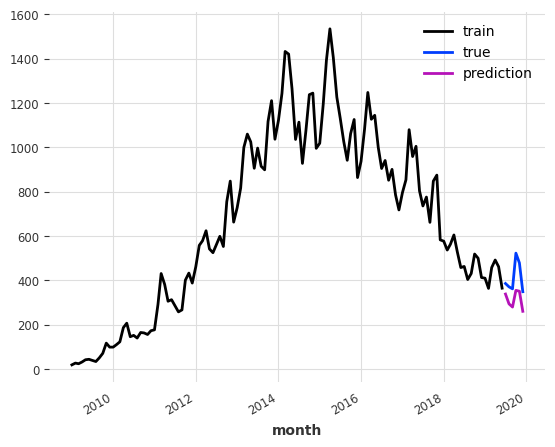

In [149]:
train.plot(label="train")
test.plot(label="true")
prediction_tbats.plot(label="prediction")

In [150]:
tbats = mape(test, prediction_tbats)
tbats

23.30709181640146

In [156]:
mape = pd.DataFrame()
mape['Nombre'] = ['ETS','ARIMA','4Theta','TBATS']
mape['MAPE'] = [ets,arima,theta,tbats]
mape.sort_values('MAPE')

,Nombre,MAPE
0,ETS,0.162788
1,ARIMA,0.242264
2,4Theta,15.932841
3,TBATS,23.307092


# Modelo Final

In [158]:
horizon = np.arange(12)
historic = df['matlab'].astype('float64').to_period('m')

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

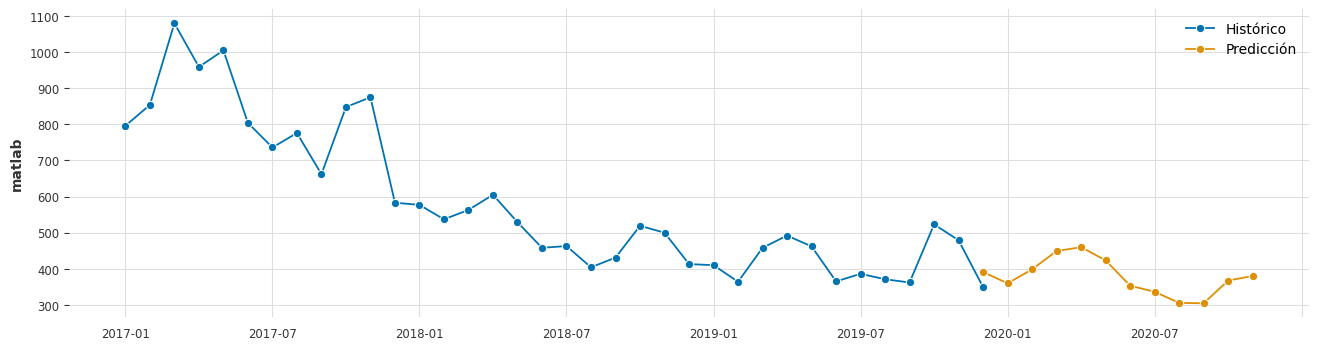

In [161]:
final_ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
final_ets_model.fit(historic)
ets_pred = final_ets_model.predict(horizon)
plot_series(historic['2017':], ets_pred, labels=["Histórico", "Predicción"])